In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.regularizers import l2
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, accuracy_score,
                              classification_report, precision_score,
                              confusion_matrix, ConfusionMatrixDisplay)
import xgboost as xgb

student_df = pd.read_csv("/content/sample_data/CourseLevelDatasetVersion2.csv")

#drop any duplicate
student_df = student_df.drop_duplicates()
#reset index in case any index was dropped
student_df.reset_index(inplace=True)

student_df.shape

(25059, 37)

In [3]:
# CHeck dataset for null
student_df.isnull().sum()

index                           0
CentreName                      0
AcademicYear                    0
LearnerCode                     0
BookingId                       0
BookingType                     0
LeadSource                      0
DiscountType                17464
DateofBirth                     0
Gender                          0
Nationality                     0
HomeCountry                   346
HomeState                   16134
HomeCity                     3448
CourseLevel                     0
CourseName                      0
CourseFirstIntakeDate           0
IsFirstIntake                   0
CourseStartDate                 0
CourseEndDate                   0
CompletedCourse                 0
NonCompletionReason         21305
ArrivedDate                     0
TerminationDate             21305
AssessedModules              2231
PassedModules                2231
FailedModules                2231
CreditWeightedAverage        2296
ProgressionDegree             875
ProgressionUni

In [4]:
# Drop features as per the instruction.
# Index column was created while reindexing the dataset after removing duplicates. This also needs to be dropped.

learner_df = student_df.drop(['index', 'BookingId','BookingType', 'LeadSource', 'DiscountType', 'Nationality', 'HomeCountry', 'HomeState', 'HomeCity', 'PresentCount', 'LateCount', 'AuthorisedAbsenceCount','ArrivedDate','NonCompletionReason', 'TerminationDate', 'CourseFirstIntakeDate', 'CourseStartDate','CourseEndDate', 'AcademicYear', 'CourseName', 'LearnerCode', 'ProgressionDegree', 'EligibleToProgress', 'AssessedModules', 'PassedModules', 'FailedModules', 'AttendancePercentage', 'ContactHours'], axis = 1)

# extended dataframe is created to include the 2 extra features.
learner_extended_df = student_df.drop(['index', 'BookingId','BookingType', 'LeadSource', 'DiscountType', 'Nationality', 'HomeCountry', 'HomeState', 'HomeCity', 'PresentCount', 'LateCount', 'AuthorisedAbsenceCount','ArrivedDate','NonCompletionReason', 'TerminationDate', 'CourseFirstIntakeDate', 'CourseStartDate','CourseEndDate', 'AcademicYear', 'CourseName', 'LearnerCode', 'ProgressionDegree', 'EligibleToProgress', 'AssessedModules', 'PassedModules', 'FailedModules'], axis = 1)


In [5]:
# Check nulls after dropping columns
print(learner_df.isnull().sum(), "\n")
print(learner_extended_df.isnull().sum())

CentreName                     0
DateofBirth                    0
Gender                         0
CourseLevel                    0
IsFirstIntake                  0
CompletedCourse                0
CreditWeightedAverage       2296
ProgressionUniversity          0
UnauthorisedAbsenceCount     208
dtype: int64 

CentreName                     0
DateofBirth                    0
Gender                         0
CourseLevel                    0
IsFirstIntake                  0
CompletedCourse                0
CreditWeightedAverage       2296
ProgressionUniversity          0
UnauthorisedAbsenceCount     208
ContactHours                 208
AttendancePercentage         208
dtype: int64


* learner_df has 2 features with nulls
* learner_extended_df has 4 features with nulls

In [6]:
# Display the 2 dataframes to visualise it and also observe null values
display(learner_df.head())
display(learner_extended_df.head())

,CentreName,DateofBirth,Gender,CourseLevel,IsFirstIntake,CompletedCourse,CreditWeightedAverage,ProgressionUniversity,UnauthorisedAbsenceCount
0,ISC_Aberdeen,13/01/1998,Male,Pre-Masters,True,Yes,75.0,University of Aberdeen,NaN
1,ISC_Aberdeen,12/02/1998,Male,Foundation,False,Yes,73.0,University of Aberdeen,5.0
2,ISC_Aberdeen,07/04/2000,Male,International Year Two,False,Yes,66.0,University of Aberdeen,6.0
3,ISC_Aberdeen,18/05/1999,Male,International Year Two,True,Yes,71.0,University of Aberdeen,15.0
4,ISC_Aberdeen,19/04/1996,Male,Pre-Masters,True,Yes,60.0,University of Aberdeen,NaN


,CentreName,DateofBirth,Gender,CourseLevel,IsFirstIntake,CompletedCourse,CreditWeightedAverage,ProgressionUniversity,UnauthorisedAbsenceCount,ContactHours,AttendancePercentage
0,ISC_Aberdeen,13/01/1998,Male,Pre-Masters,True,Yes,75.0,University of Aberdeen,NaN,NaN,NaN
1,ISC_Aberdeen,12/02/1998,Male,Foundation,False,Yes,73.0,University of Aberdeen,5.0,215.0,97.0
2,ISC_Aberdeen,07/04/2000,Male,International Year Two,False,Yes,66.0,University of Aberdeen,6.0,226.0,97.0
3,ISC_Aberdeen,18/05/1999,Male,International Year Two,True,Yes,71.0,University of Aberdeen,15.0,399.0,94.0
4,ISC_Aberdeen,19/04/1996,Male,Pre-Masters,True,Yes,60.0,University of Aberdeen,NaN,NaN,NaN


In [7]:
#  Remove any row that has null values.
learner_df.dropna(inplace=True)
learner_extended_df.dropna(inplace=True)

In [8]:
# Feature Engineering
# Engineer Age from the DateofBirth feature

def convert_dob_to_age(dataframe):
  # Convert DateofBirth to datetime
  dataframe['DOB'] = pd.to_datetime(dataframe['DateofBirth'], format='%d/%m/%Y')

  # Calculate age
  today = pd.Timestamp('now')
  dataframe['Age']  = ((today - dataframe['DOB']).dt.days / 365).round(0)

  #drop intermediary and original column
  dataframe.drop(['DateofBirth', 'DOB'], axis = 1, inplace=True)

  return dataframe

# Apply Age feature on learner_df
learner_df = convert_dob_to_age(learner_df)
# Apply Age feature on learner_extended_df
learner_extended_df = convert_dob_to_age(learner_extended_df)

In [11]:
# Check dataframes for null values to confirm all null values have been dropped
print(learner_df.isnull().sum(), "\n")
print(learner_extended_df.isnull().sum())

CentreName                  0
Gender                      0
CourseLevel                 0
IsFirstIntake               0
CompletedCourse             0
CreditWeightedAverage       0
ProgressionUniversity       0
UnauthorisedAbsenceCount    0
Age                         0
dtype: int64 

CentreName                  0
Gender                      0
CourseLevel                 0
IsFirstIntake               0
CompletedCourse             0
CreditWeightedAverage       0
ProgressionUniversity       0
UnauthorisedAbsenceCount    0
ContactHours                0
AttendancePercentage        0
Age                         0
dtype: int64


In [12]:
# Check dataframe info to check further details

display(learner_df.info())
display(learner_extended_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 22686 entries, 1 to 25058
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                22686 non-null  object 
 1   Gender                    22686 non-null  object 
 2   CourseLevel               22686 non-null  object 
 3   IsFirstIntake             22686 non-null  bool   
 4   CompletedCourse           22686 non-null  object 
 5   CreditWeightedAverage     22686 non-null  float64
 6   ProgressionUniversity     22686 non-null  object 
 7   UnauthorisedAbsenceCount  22686 non-null  float64
 8   Age                       22686 non-null  float64
dtypes: bool(1), float64(3), object(5)
memory usage: 1.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 22686 entries, 1 to 25058
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                22686 non-null  object 
 1   Gender                    22686 non-null  object 
 2   CourseLevel               22686 non-null  object 
 3   IsFirstIntake             22686 non-null  bool   
 4   CompletedCourse           22686 non-null  object 
 5   CreditWeightedAverage     22686 non-null  float64
 6   ProgressionUniversity     22686 non-null  object 
 7   UnauthorisedAbsenceCount  22686 non-null  float64
 8   ContactHours              22686 non-null  float64
 9   AttendancePercentage      22686 non-null  float64
 10  Age                       22686 non-null  float64
dtypes: bool(1), float64(5), object(5)
memory usage: 1.9+ MB


None

In [13]:
# Display the 2 dataframes to visualise it after dropping null and feature engineering
display(learner_df.head())
display(learner_extended_df.head())

,CentreName,Gender,CourseLevel,IsFirstIntake,CompletedCourse,CreditWeightedAverage,ProgressionUniversity,UnauthorisedAbsenceCount,Age
1,ISC_Aberdeen,Male,Foundation,False,Yes,73.0,University of Aberdeen,5.0,26.0
2,ISC_Aberdeen,Male,International Year Two,False,Yes,66.0,University of Aberdeen,6.0,24.0
3,ISC_Aberdeen,Male,International Year Two,True,Yes,71.0,University of Aberdeen,15.0,25.0
5,ISC_Aberdeen,Male,International Year Two,True,Yes,78.0,University of Aberdeen,3.0,24.0
7,ISC_Aberdeen,Male,Foundation,False,Yes,68.0,University of Aberdeen,25.0,23.0


,CentreName,Gender,CourseLevel,IsFirstIntake,CompletedCourse,CreditWeightedAverage,ProgressionUniversity,UnauthorisedAbsenceCount,ContactHours,AttendancePercentage,Age
1,ISC_Aberdeen,Male,Foundation,False,Yes,73.0,University of Aberdeen,5.0,215.0,97.0,26.0
2,ISC_Aberdeen,Male,International Year Two,False,Yes,66.0,University of Aberdeen,6.0,226.0,97.0,24.0
3,ISC_Aberdeen,Male,International Year Two,True,Yes,71.0,University of Aberdeen,15.0,399.0,94.0,25.0
5,ISC_Aberdeen,Male,International Year Two,True,Yes,78.0,University of Aberdeen,3.0,371.0,99.0,24.0
7,ISC_Aberdeen,Male,Foundation,False,Yes,68.0,University of Aberdeen,25.0,214.0,86.0,23.0


In [14]:
# Check ProgressionUniversity column.
learner_df['ProgressionUniversity'].unique()

array(['University of Aberdeen', 'Cardiff University',
       'University College Dublin', 'Durham University',
       'Strathclyde University', 'Coventry University London',
       'Holland ISC - Erasmus University Rotterdam',
       'Holland ISC - VU Amsterdam', 'Holland ISC - Hanze UAS',
       'Holland ISC - Erasmus University Rotterdam/ Tilburg University',
       'Holland ISC - Tilburg University',
       'Holland ISC - VU Amsterdam/ Military service',
       'Outside of partnership',
       'Holland ISC - Erasmus University Rotterdam/ Holland ISC - Tilburg University',
       'Holland ISC - Erasmus University Rotterdam/Holland ISC - VU Amsterdam',
       'Holland ISC - Tilburg University/VU Amsterdam/Hanze',
       'Holland ISC - Erasmus University Rotterdam/Holland ISC - Tilburg University',
       'Holland ISC - Erasmus University Rotterdam/Tilburg University',
       'Holland ISC - Hanze UAS/VU Amsterdam', 'Tilburg University',
       'VU Amsterdam', 'Erasmus Rotterdam', 'Han

ProgressionUniversity contains inconsistent values.

eg Strathclyde University and University of Strathclyde

VU Amsterdam and Holland ISC - VU Amsterdam

This needs to be normalised

In [62]:
# Normalise inconsistent entries
def normalise_university(dataframe):
  dataframe.loc[dataframe['ProgressionUniversity'] == 'Erasmus Rotterdam', 'ProgressionUniversity'] = 'Holland ISC - Erasmus University Rotterdam'
  dataframe.loc[dataframe['ProgressionUniversity'] == 'VU Amsterdam', 'ProgressionUniversity'] = 'Holland ISC - VU Amsterdam'
  dataframe.loc[dataframe['ProgressionUniversity'] == 'Hanze UAS', 'ProgressionUniversity'] = 'Holland ISC - Hanze UAS'
  dataframe.loc[dataframe['ProgressionUniversity'] == 'Tilburg University', 'ProgressionUniversity'] = 'Holland ISC - Tilburg University'
  dataframe.loc[dataframe['ProgressionUniversity'] == 'Holland ISC - Erasmus University Rotterdam/ Holland ISC - Tilburg University', 'ProgressionUniversity'] = 'Holland ISC - Erasmus University Rotterdam,Holland ISC - Tilburg University'
  dataframe.loc[dataframe['ProgressionUniversity'] == 'Holland ISC - Erasmus University Rotterdam/Holland ISC - Tilburg University', 'ProgressionUniversity'] = 'Holland ISC - Erasmus University Rotterdam,Holland ISC - Tilburg University'
  dataframe.loc[dataframe['ProgressionUniversity'] == 'Holland ISC - Erasmus University Rotterdam/ Tilburg University', 'ProgressionUniversity'] = 'Holland ISC - Erasmus University Rotterdam,Holland ISC - Tilburg University'
  dataframe.loc[dataframe['ProgressionUniversity'] == 'Holland ISC - Erasmus University Rotterdam/Tilburg University', 'ProgressionUniversity'] = 'Holland ISC - Erasmus University Rotterdam,Holland ISC - Tilburg University'
  dataframe.loc[dataframe['ProgressionUniversity'] == 'Holland ISC - Erasmus University Rotterdam/Holland ISC - VU Amsterdam', 'ProgressionUniversity'] = 'Holland ISC - Erasmus University Rotterdam,Holland ISC - VU Amsterdam'

  dataframe.loc[dataframe['ProgressionUniversity'] == 'Holland ISC - Hanze UAS/VU Amsterdam', 'ProgressionUniversity'] = 'Holland ISC - Hanze UAS,Holland ISC - VU Amsterdam'
  dataframe.loc[dataframe['ProgressionUniversity'] == 'Holland ISC - Tilburg University/VU Amsterdam/Hanze', 'ProgressionUniversity'] = 'Holland ISC - Tilburg University,Holland ISC - VU Amsterdam,Holland ISC - Hanze UAS'
  dataframe.loc[dataframe['ProgressionUniversity'] == 'Holland ISC - VU Amsterdam/ Military service', 'ProgressionUniversity'] = 'Holland ISC - VU Amsterdam,Military service'

  dataframe.loc[dataframe['ProgressionUniversity'] == 'Strathclyde University', 'ProgressionUniversity'] = 'University of Strathclyde'
  return dataframe

In [63]:
# Normalise ProgressionUniversity on both dataframes
learner_df = normalise_university(learner_df)
learner_extended_df = normalise_university(learner_extended_df)

# ProgressionUniversity is a multivalue column. Explode the dataframe to ensure each row contains only one value for ProgressionUniversity
learner_df = learner_df.assign(ProgressionUniversity=learner_df['ProgressionUniversity'].str.split(',')).explode('ProgressionUniversity')
learner_extended_df = learner_extended_df.assign(ProgressionUniversity=learner_extended_df['ProgressionUniversity'].str.split(',')).explode('ProgressionUniversity')

In [15]:
# Visualise the dataframes after having performed all necessary feature engineering
display(learner_df.head())
display(learner_extended_df.head())

,CentreName,Gender,CourseLevel,IsFirstIntake,CompletedCourse,CreditWeightedAverage,ProgressionUniversity,UnauthorisedAbsenceCount,Age
1,ISC_Aberdeen,Male,Foundation,False,Yes,73.0,University of Aberdeen,5.0,26.0
2,ISC_Aberdeen,Male,International Year Two,False,Yes,66.0,University of Aberdeen,6.0,24.0
3,ISC_Aberdeen,Male,International Year Two,True,Yes,71.0,University of Aberdeen,15.0,25.0
5,ISC_Aberdeen,Male,International Year Two,True,Yes,78.0,University of Aberdeen,3.0,24.0
7,ISC_Aberdeen,Male,Foundation,False,Yes,68.0,University of Aberdeen,25.0,23.0


,CentreName,Gender,CourseLevel,IsFirstIntake,CompletedCourse,CreditWeightedAverage,ProgressionUniversity,UnauthorisedAbsenceCount,ContactHours,AttendancePercentage,Age
1,ISC_Aberdeen,Male,Foundation,False,Yes,73.0,University of Aberdeen,5.0,215.0,97.0,26.0
2,ISC_Aberdeen,Male,International Year Two,False,Yes,66.0,University of Aberdeen,6.0,226.0,97.0,24.0
3,ISC_Aberdeen,Male,International Year Two,True,Yes,71.0,University of Aberdeen,15.0,399.0,94.0,25.0
5,ISC_Aberdeen,Male,International Year Two,True,Yes,78.0,University of Aberdeen,3.0,371.0,99.0,24.0
7,ISC_Aberdeen,Male,Foundation,False,Yes,68.0,University of Aberdeen,25.0,214.0,86.0,23.0


In [65]:
#Encode the categorical features with one hot encoder
def one_hot_encoder(dataframe):
  dataframe = pd.get_dummies(dataframe, columns=['CentreName'], drop_first=True)
  dataframe = pd.get_dummies(dataframe, columns=['Gender'], drop_first=True)
  dataframe = pd.get_dummies(dataframe, columns=['CourseLevel'], drop_first=True)
  dataframe = pd.get_dummies(dataframe, columns=['IsFirstIntake'], drop_first=True)
  dataframe = pd.get_dummies(dataframe, columns=['ProgressionUniversity'], drop_first=True)
  return dataframe

# Apply ending to both dataframes
learner_df = one_hot_encoder(learner_df)
learner_extended_df = one_hot_encoder(learner_extended_df)

In [66]:
# Display descriptive statistics for both datasets
display(learner_df.describe())
display(learner_extended_df.describe())

,CreditWeightedAverage,UnauthorisedAbsenceCount,Age
count,22698.000000,22698.000000,22698.000000
mean,62.797471,37.697286,24.025949
std,19.323025,37.171934,3.201503
min,0.000000,0.000000,18.000000
25%,60.000000,11.000000,22.000000
50%,67.000000,27.000000,23.000000
75%,74.000000,52.000000,26.000000
max,98.000000,343.000000,62.000000


,CreditWeightedAverage,UnauthorisedAbsenceCount,ContactHours,AttendancePercentage,Age
count,22698.000000,22698.000000,22698.000000,22698.000000,22698.000000
mean,62.797471,37.697286,394.390431,84.844744,24.025949
std,19.323025,37.171934,106.420786,15.623854,3.201503
min,0.000000,0.000000,44.000000,1.000000,18.000000
25%,60.000000,11.000000,334.000000,80.000000,22.000000
50%,67.000000,27.000000,398.000000,89.000000,23.000000
75%,74.000000,52.000000,482.750000,96.000000,26.000000
max,98.000000,343.000000,792.000000,100.000000,62.000000


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'UnauthorisedAbsenceCount'}>,
        <Axes: title={'center': 'CreditWeightedAverage'}>],
       [<Axes: title={'center': 'ContactHours'}>,
        <Axes: title={'center': 'AttendancePercentage'}>, <Axes: >]],
      dtype=object)

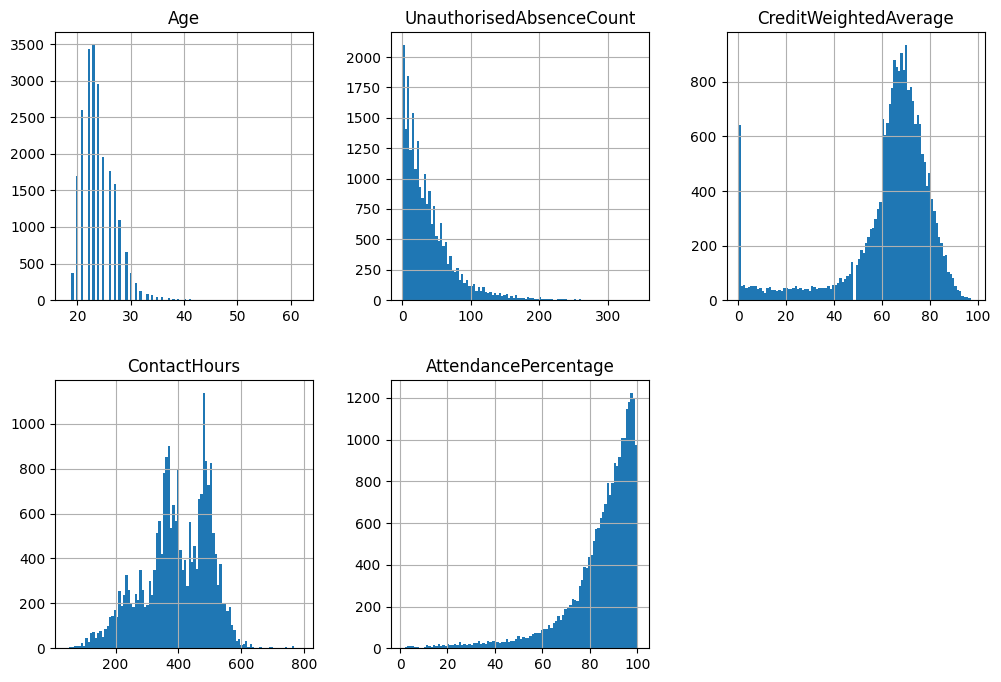

In [67]:
# Plot histogram for the 5 numerical features
learner_extended_df[['Age', 'UnauthorisedAbsenceCount', 'CreditWeightedAverage', 'ContactHours', 'AttendancePercentage']].hist(figsize=(12, 8), bins=100, layout=(2,3))

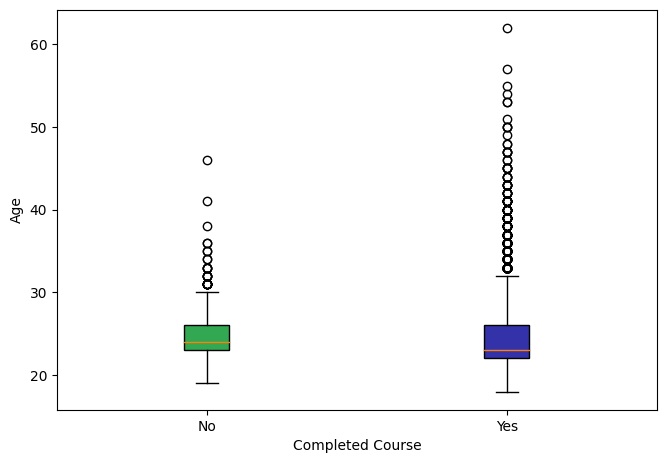

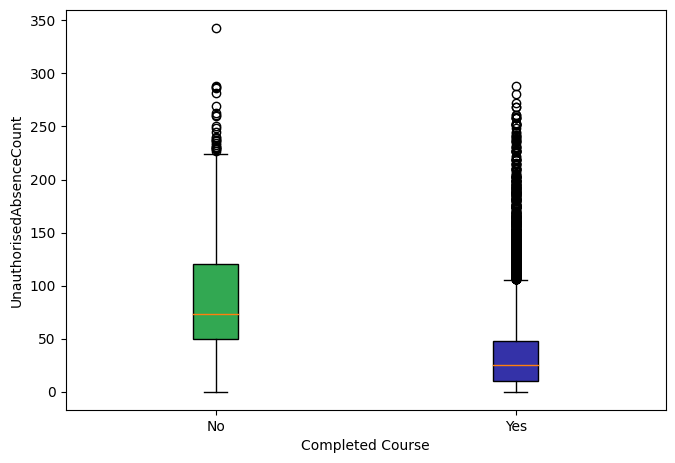

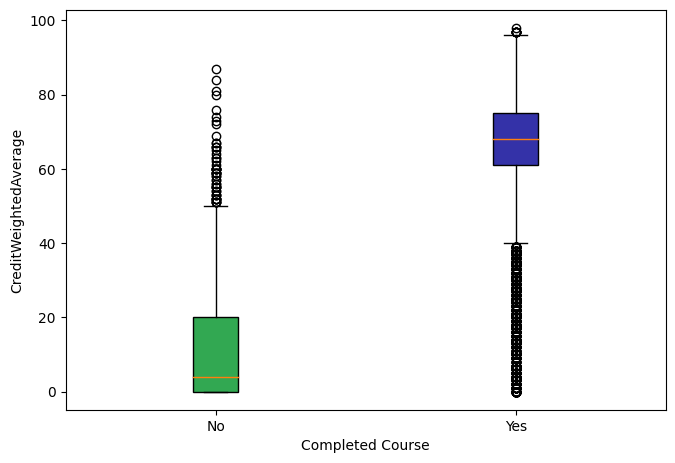

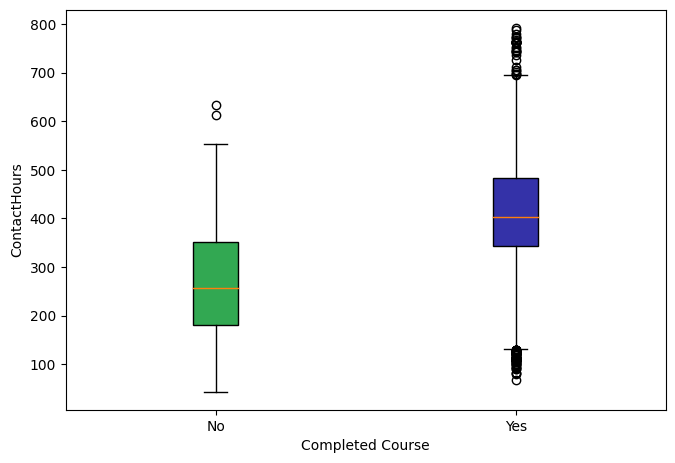

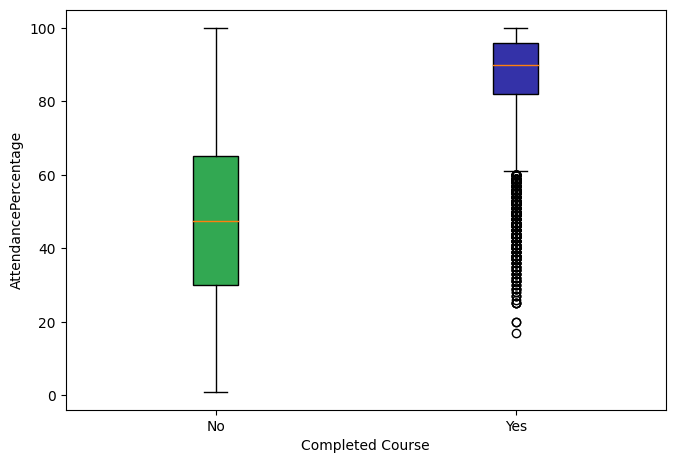

In [68]:
#boxplots of the input features, grouped by target variable.

def plot_boxPlots(column):
        data = [learner_extended_df[learner_extended_df['CompletedCourse'] == 'No'][column],
                learner_extended_df[learner_extended_df['CompletedCourse'] == 'Yes'][column]]

        fig = plt.figure(figsize =(6, 4))

        # Creating axes instance
        ax = fig.add_axes([0, 0, 1, 1])

        # Creating plot
        bp = ax.boxplot(data, patch_artist = True, labels=["No","Yes"])

        colors = ['#32a852', '#3432a8']

        for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)

        # show plot
        plt.xlabel('Completed Course')
        plt.ylabel(column)
        plt.show()

# invoke function to plot the box plots
plot_boxPlots('Age')
plot_boxPlots('UnauthorisedAbsenceCount')
plot_boxPlots('CreditWeightedAverage')
plot_boxPlots('ContactHours')
plot_boxPlots('AttendancePercentage')

In [69]:
# Standardise numerical features

# Instantiate StandardScaler() object
std = StandardScaler()

# Create a copy of the detaframe
learner_scaled_df = learner_df.copy()

# Standardise numerical features in learner_scaled_df
learner_scaled_df['CreditWeightedAverage'] = std.fit_transform(learner_scaled_df[['CreditWeightedAverage']])
learner_scaled_df['UnauthorisedAbsenceCount'] = std.fit_transform(learner_scaled_df[['UnauthorisedAbsenceCount']])
learner_scaled_df['Age'] = std.fit_transform(learner_scaled_df[['Age']])

# Visualise learner_scaled_df after scaling the features
display(learner_scaled_df)

# Create a copy of the detaframe
learner_extended_scaled_df = learner_extended_df.copy()

# Standardise numerical features in learner_extended_scaled_df
learner_extended_scaled_df['CreditWeightedAverage'] = std.fit_transform(learner_extended_scaled_df[['CreditWeightedAverage']])
learner_extended_scaled_df['UnauthorisedAbsenceCount'] = std.fit_transform(learner_extended_scaled_df[['UnauthorisedAbsenceCount']])
learner_extended_scaled_df['Age'] = std.fit_transform(learner_extended_scaled_df[['Age']])
learner_extended_scaled_df['AttendancePercentage'] = std.fit_transform(learner_extended_scaled_df[['AttendancePercentage']])
learner_extended_scaled_df['ContactHours'] = std.fit_transform(learner_extended_scaled_df[['ContactHours']])

# Visualise learner_extended_scaled_df after scaling the features
display(learner_extended_scaled_df)

,CompletedCourse,CreditWeightedAverage,UnauthorisedAbsenceCount,Age,CentreName_ISC_Cardiff,CentreName_ISC_Dublin,CentreName_ISC_Durham,CentreName_ISC_Holland,CentreName_ISC_Huddersfield,CentreName_ISC_Kingston,...,ProgressionUniversity_UK Online Pathways,ProgressionUniversity_University College Dublin,ProgressionUniversity_University of Aberdeen,ProgressionUniversity_University of Huddersfield,ProgressionUniversity_University of Leeds,ProgressionUniversity_University of Lincoln,ProgressionUniversity_University of Sheffield International College,ProgressionUniversity_University of Strathclyde,ProgressionUniversity_University of Surrey,ProgressionUniversity_University of Sussex
1,Yes,0.528010,-0.879642,0.616615,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,Yes,0.165740,-0.852740,-0.008106,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,Yes,0.424504,-0.610616,0.304255,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
5,Yes,0.786775,-0.933448,-0.008106,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
7,Yes,0.269246,-0.341590,-0.320466,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25053,Yes,-0.558800,-1.014155,0.928975,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
25054,Yes,-0.610553,-0.906545,2.490776,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
25055,Yes,0.786775,-1.014155,1.553695,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
25056,Yes,0.786775,-0.960350,0.928975,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


,CompletedCourse,CreditWeightedAverage,UnauthorisedAbsenceCount,ContactHours,AttendancePercentage,Age,CentreName_ISC_Cardiff,CentreName_ISC_Dublin,CentreName_ISC_Durham,CentreName_ISC_Holland,...,ProgressionUniversity_UK Online Pathways,ProgressionUniversity_University College Dublin,ProgressionUniversity_University of Aberdeen,ProgressionUniversity_University of Huddersfield,ProgressionUniversity_University of Leeds,ProgressionUniversity_University of Lincoln,ProgressionUniversity_University of Sheffield International College,ProgressionUniversity_University of Strathclyde,ProgressionUniversity_University of Surrey,ProgressionUniversity_University of Sussex
1,Yes,0.528010,-0.879642,-1.685708,0.778011,0.616615,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,Yes,0.165740,-0.852740,-1.582343,0.778011,-0.008106,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,Yes,0.424504,-0.610616,0.043316,0.585992,0.304255,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
5,Yes,0.786775,-0.933448,-0.219797,0.906023,-0.008106,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
7,Yes,0.269246,-0.341590,-1.695105,0.073943,-0.320466,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25053,Yes,-0.558800,-1.014155,-1.817264,0.970029,0.928975,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
25054,Yes,-0.610553,-0.906545,-1.817264,0.714004,2.490776,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
25055,Yes,0.786775,-1.014155,-1.817264,0.970029,1.553695,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
25056,Yes,0.786775,-0.960350,-1.676311,0.842017,0.928975,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [71]:
# Split dataset into input features X and target variable y
X = learner_scaled_df.drop('CompletedCourse', axis=1).copy()
y = learner_scaled_df['CompletedCourse'].copy()

X.replace({False: 0, True: 1}, inplace=True)

In [73]:
# encode the target variable
lbe = LabelEncoder()
y = pd.DataFrame(lbe.fit_transform(y))
y

,0
0,1
1,1
2,1
3,1
4,1
...,...
22693,1
22694,1
22695,1
22696,1


In [74]:
# Check output variable imbalance
y.value_counts(normalize=True)

1    0.936382
0    0.063618
Name: proportion, dtype: float64

array([[<Axes: title={'center': '0'}>]], dtype=object)

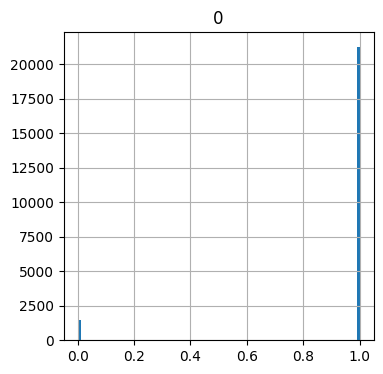

In [77]:
# plot histogram of the target variable to visualise the imbalance
y.hist(figsize=(4, 4), bins=100, layout=(1,1))

In [75]:
# Visualise a heatmap to display the correlation matrix.

def plot_corr_matrix(x_df, method):
  plt.figure(figsize=(100, 100))
  corr_matrix = x_df.corr(method=method)

  sns.heatmap(corr_matrix,
              annot=True,
              cmap='coolwarm',
              linewidths=1.5,
              annot_kws={"fontsize": 16, "fontweight": "bold"})

  plt.title('{0} correlation'.format(method))
  plt.show()

# Plot spearman correlation matrix
plot_corr_matrix(X, method='spearman')

Output hidden; open in https://colab.research.google.com to view.

In [76]:
# Drop features that has very high correlation with other features
X.drop(["CentreName_ISC_Dublin", "CentreName_ISC_Durham", "CentreName_ISC_Huddersfield",
        "CentreName_ISC_Kingston", "CentreName_ISC_LJMU", "CentreName_ISC_Lancaster",
        "CentreName_ISC_Leeds", "CentreName_ISC_Lincoln", "CentreName_ISC_London",
        "CentreName_ISC_RHUL", "CentreName_ISC_Sheffield", "CentreName_ISC_Strathclyde",
        "CentreName_ISC_Surrey", "CentreName_ISC_Sussex", "CentreName_ISC_Teesside"], axis = 1, inplace=True)

# Plot spearman correlation matrix
plot_corr_matrix(X, method='spearman')

Output hidden; open in https://colab.research.google.com to view.

In [86]:
seed = 42

# split input and target variables into training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, stratify=y, random_state=seed, test_size=0.2)

# XGBoost

XG Boost Basic Model Accuracy:  0.9665198237885463
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       289
           1       0.98      0.98      0.98      4251

    accuracy                           0.97      4540
   macro avg       0.87      0.84      0.85      4540
weighted avg       0.97      0.97      0.97      4540



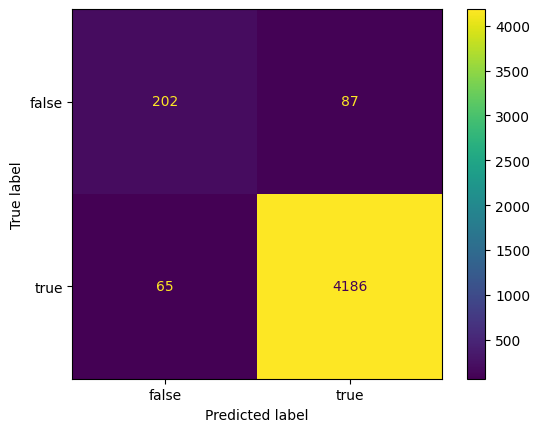

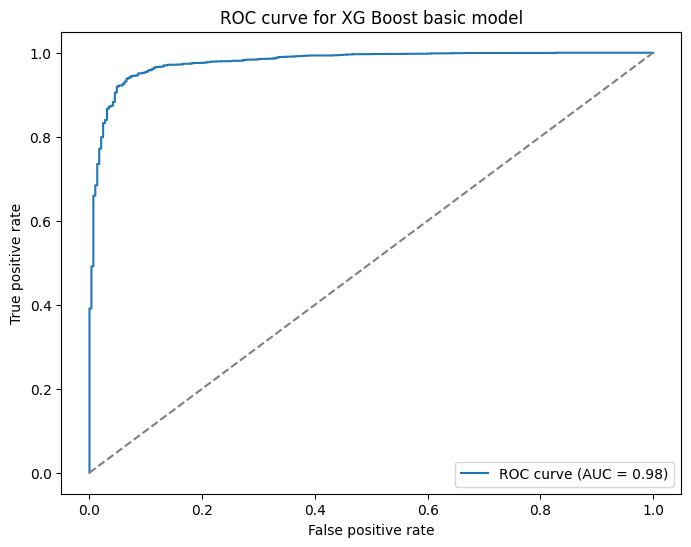

In [87]:
# define function to plot correlation matrix
def plot_confusion_matrix(label, predictions):
  print(label, accuracy_score(y_test, predictions))
  print(classification_report(y_test, predictions))

  cm = confusion_matrix(y_test, predictions)
  cfmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["false","true"])
  cfmd.plot()
  plt.show()

# define function to plot ROC_AUC curve
def plot_ROC_AUC(label, model, X_test):
  # Predict the probabilities of the positive class on the test set.
  y_proba = model.predict_proba(X_test)[:, 1]

  # Compute the ROC curve and the AUC score.
  fpr, tpr, thresholds = roc_curve(y_test, y_proba)
  auc_score = roc_auc_score(y_test, y_proba)
  auc_value = auc(fpr, tpr)

  # Plot the ROC curve and show the AUC score.
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title(label)
  plt.legend()
  plt.show()

# Instantiate XGBClassifier with default hyperparameter
xgb_basic = xgb.XGBClassifier(random_state=seed)

# train the model
xgb_basic.fit(X_train, y_train)

# predict the target with test dataset
xgb_basic_predictions = xgb_basic.predict(X_test)

# plot confusion matrix
plot_confusion_matrix("XG Boost Basic Model Accuracy: ", xgb_basic_predictions)

# plot ROC_AUC curve
plot_ROC_AUC("ROC curve for XG Boost basic model", xgb_basic, X_test)

In [88]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 15, 20, 25],
    'max_depth': [None, 10, 15, 20],
    'learning_rate': [.3, .4, .5, .6, .7]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_basic, param_grid=param_grid, cv=5, scoring='accuracy', refit=True)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Evaluate on the test set
test_score = grid_search.score(X_test, y_test)
print(f"Test Score: {test_score}")


Best Parameters: {'learning_rate': 0.3, 'max_depth': None, 'n_estimators': 15}
Best Cross-Validation Score: 0.9721883541990956
Test Score: 0.970704845814978


XG Boost tuned Model Accuracy:  0.970704845814978
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       289
           1       0.98      0.99      0.98      4251

    accuracy                           0.97      4540
   macro avg       0.89      0.86      0.87      4540
weighted avg       0.97      0.97      0.97      4540



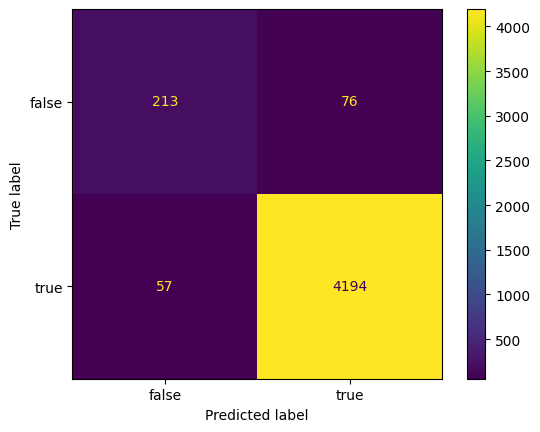

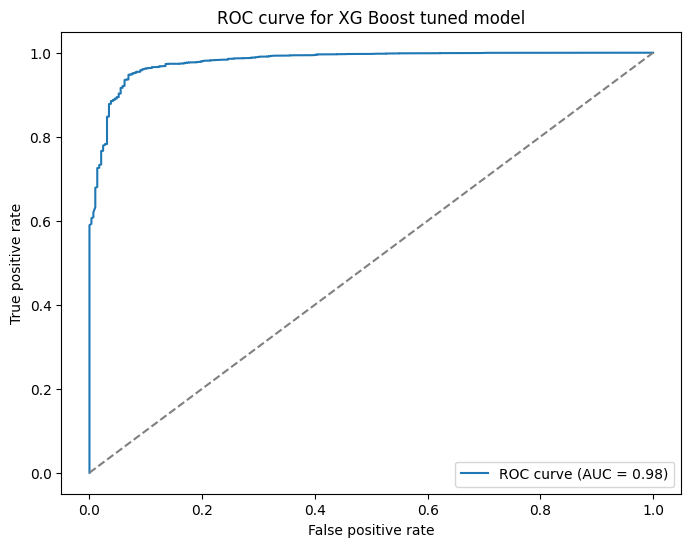

In [89]:
# Instantiate XGBClassifier with best hyperparameter
xgb_tuned = xgb.XGBClassifier(random_state=seed, **best_params)
# train the model
xgb_tuned.fit(X_train, y_train)
# predict the target with test dataset
xgb_tuned_predictions = xgb_tuned.predict(X_test)

# plot confusion matrix
plot_confusion_matrix("XG Boost tuned Model Accuracy: ", xgb_tuned_predictions)
# plot ROC_AUC curve
plot_ROC_AUC("ROC curve for XG Boost tuned model", xgb_tuned, X_test)

After dropping colinear features

* XG Boost Basic Model Accuracy:  0.968942731277533
* XG Boost tuned Model Accuracy:  0.9711453744493392

Without dropping multi-colinear features

* XG Boost Basic Model Accuracy:  0.9662995594713656
* XG Boost tuned Model Accuracy:  0.968942731277533


The XGBoost basic model predicted with 96.65% accuracy.

Although the accuracy is higher that the positive class percentage. The False Positive is higher than False Negative. Ideally we would like False Positive to be as low as possible.


GridSearchCV gave the following as the best parameters:
*	'learning_rate': 0.3
*	'max_depth': None
*	'n_estimators': 15

Using the hyperparameter values tuned by GridSearchCV, the XGBoost model gave 97.07% accuracy, improving both the precision and recall for both positive and negative class.

# XGBoost with additional features: AttendancePercentage and ContactHours

In [93]:
# Split extended dataset into input features X and target variable y
X_extended = learner_extended_scaled_df.drop('CompletedCourse', axis=1).copy()
X_extended.replace({False: 0, True: 1}, inplace=True)

# split input and target variables into training and test sets
X_extended_train, X_extended_test, y_train, y_test= train_test_split(X_extended, y, stratify=y, random_state=seed, test_size=0.2)

XG Boost Basic Model Accuracy:  0.9801762114537445
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       289
           1       0.99      0.99      0.99      4251

    accuracy                           0.98      4540
   macro avg       0.92      0.91      0.92      4540
weighted avg       0.98      0.98      0.98      4540



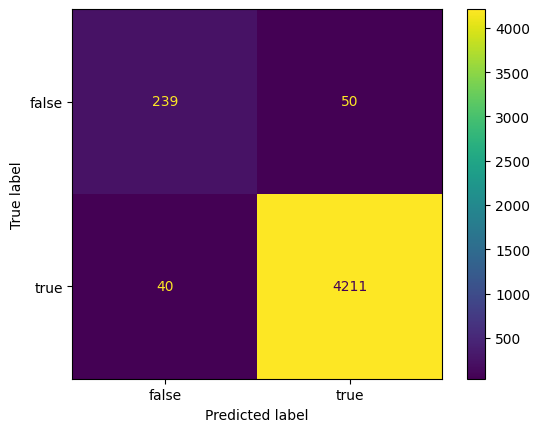

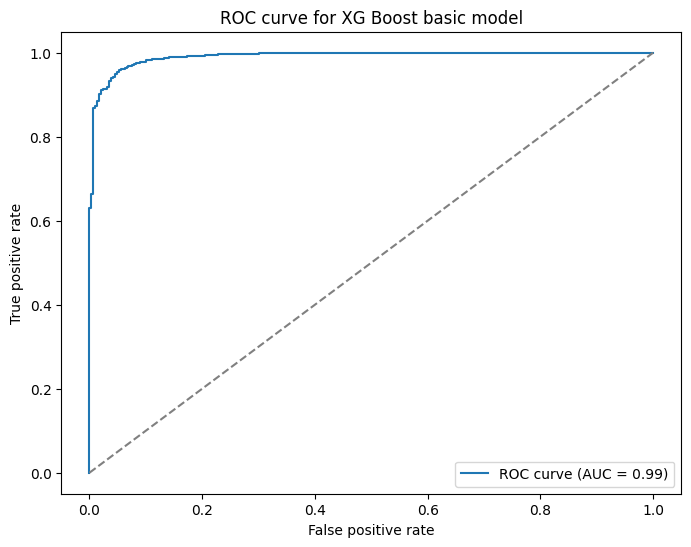

In [94]:
#XGBoost model on the dataset with additional features

xgb_extended_basic = xgb.XGBClassifier(random_state=seed)
xgb_extended_basic.fit(X_extended_train, y_train)
xgb_extended_basic_predictions = xgb_extended_basic.predict(X_extended_test)

plot_confusion_matrix("XG Boost Basic Model Accuracy: ", xgb_extended_basic_predictions)
plot_ROC_AUC("ROC curve for XG Boost basic model", xgb_extended_basic, X_extended_test)

In [95]:
# Hyperparameter tuning

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 15, 20, 25],
    'max_depth': [None, 10, 15, 20],
    'learning_rate': [.3, .4, .5, .6, .7]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_extended_basic, param_grid=param_grid, cv=5, scoring='accuracy', refit=True)

# Fit the model
grid_search.fit(X_extended_train, y_train)

# Get the best parameters and score
best_extended_params = grid_search.best_params_
best_extended_score = grid_search.best_score_

print(f"Best Parameters: {best_extended_params}")
print(f"Best Cross-Validation Score: {best_extended_score}")

# Evaluate on the test set
test_extended_score = grid_search.score(X_extended_test, y_test)
print(f"Test Score: {test_extended_score}")


Best Parameters: {'learning_rate': 0.6, 'max_depth': 20, 'n_estimators': 25}
Best Cross-Validation Score: 0.9793479909297933
Test Score: 0.9784140969162995


XG Boost tuned Model Accuracy:  0.9784140969162995
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       289
           1       0.99      0.99      0.99      4251

    accuracy                           0.98      4540
   macro avg       0.92      0.90      0.91      4540
weighted avg       0.98      0.98      0.98      4540



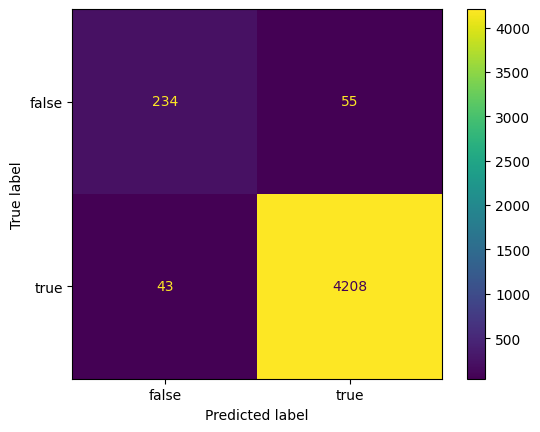

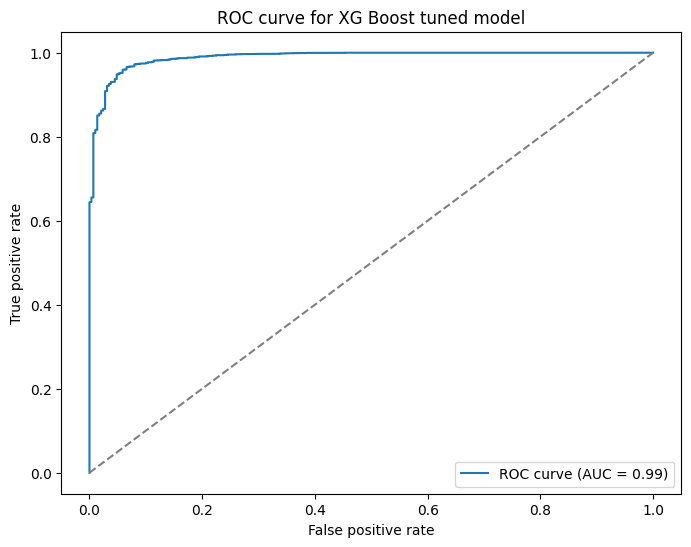

In [96]:
#XGBoost model on the dataset with additional features applying the best parameters

xgb_extended_tuned = xgb.XGBClassifier(random_state=seed, **best_extended_params)
xgb_extended_tuned.fit(X_extended_train, y_train)
xgb_extended_tuned_predictions = xgb_extended_tuned.predict(X_extended_test)

plot_confusion_matrix("XG Boost tuned Model Accuracy: ", xgb_extended_tuned_predictions)
plot_ROC_AUC("ROC curve for XG Boost tuned model", xgb_extended_tuned, X_extended_test)

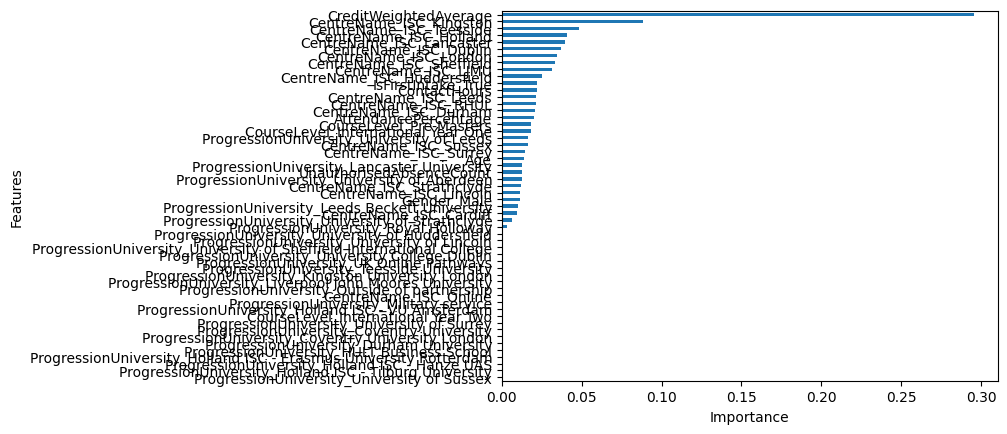

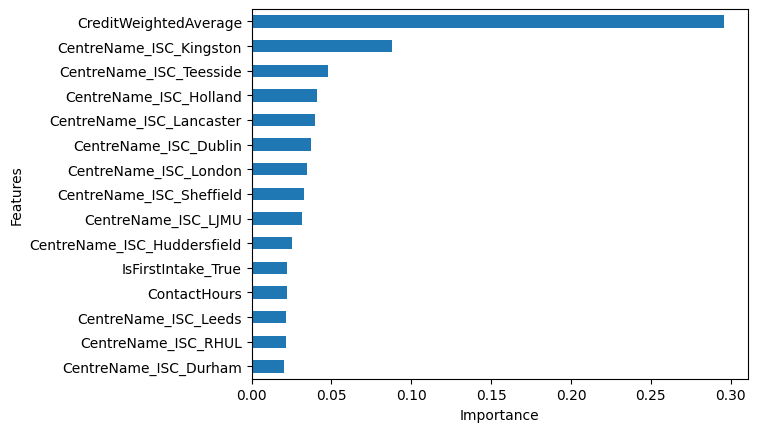

In [97]:
# plot feature importance
feature_importance = pd.Series(xgb_extended_basic.feature_importances_, index=X_extended_train.columns).sort_values()

# plot all features with their importance
feature_importance.plot.barh()
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

#plot top 15 features according to importance
feature_importance.iloc[-15:].plot.barh()
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

XG Boost with additional features

* XG Boost Basic Model Accuracy:  0.9801762114537445
* XG Boost tuned Model Accuracy:  0.9784140969162995

The XGBoost with additional features predicted with 98.01% accuracy.

The False Positive is still higher than False Negative although the absolute numbers have reduced compared to models with reduced features.


GridSearchCV gave the following as the best parameters:
*	'learning_rate': 0.6
*	'max_depth': 20
*	'n_estimators': 25

Using the hyperparameter values tuned by GridSearchCV, the XGBoost model gave 97.84% accuracy, resulting in slight degradation in the precision and recall for the negative class.

# Neural Network model

In [98]:
# keep a backup of the target training dataset. This will be used with dataset with additional features.
y_train_backup = y_train.copy()


# split training data into training and validation data
X_train, X_valid, y_train, y_valid= train_test_split(X_train, y_train, stratify=y_train, random_state=seed, test_size=0.2)

In [119]:
# Import necessary functions.
from keras.models import Sequential
from keras.layers import Dense

# Create a sequential model.
nn_basic_model = Sequential()

# Add dense layers to the model.
# First hidden layer with 128 units and ReLU activation.
nn_basic_model.add(Dense(units=128, activation='relu', input_shape=X_train.shape[1:]))

# Second hidden layer with 64 units and ReLU activation.
nn_basic_model.add(Dense(units=64, activation='relu'))

# Output hidden layer with 1 unit (classes) and sigmoid activation.
nn_basic_model.add(Dense(units=1, activation='sigmoid'))

nn_basic_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 128)               4864      
                                                                 
 dense_71 (Dense)            (None, 64)                8256      
                                                                 
 dense_72 (Dense)            (None, 1)                 65        
                                                                 
Total params: 13185 (51.50 KB)
Trainable params: 13185 (51.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [120]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

optimizer = Adam(learning_rate=0.001)
# Compile the model.

nn_basic_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])

# Fit/Train the model.
nn_basic_history = nn_basic_model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_valid, y_valid))

# Evaluate the model.
loss, accuracy = nn_basic_model.evaluate(X_test, y_test)

# View the output.
print("\nShape of training data (y_train): ", y_train.shape)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/10
227/227 [==============================] - 4s 11ms/step - loss: 0.1380 - auc: 0.9432 - val_loss: 0.0920 - val_auc: 0.9694
Epoch 2/10
227/227 [==============================] - 1s 4ms/step - loss: 0.0742 - auc: 0.9783 - val_loss: 0.0833 - val_auc: 0.9732
Epoch 3/10
227/227 [==============================] - 3s 12ms/step - loss: 0.0699 - auc: 0.9817 - val_loss: 0.0799 - val_auc: 0.9750
Epoch 4/10
227/227 [==============================] - 2s 8ms/step - loss: 0.0687 - auc: 0.9830 - val_loss: 0.0840 - val_auc: 0.9745
Epoch 5/10
227/227 [==============================] - 1s 3ms/step - loss: 0.0671 - auc: 0.9832 - val_loss: 0.0798 - val_auc: 0.9763
Epoch 6/10
227/227 [==============================] - 2s 9ms/step - loss: 0.0658 - auc: 0.9840 - val_loss: 0.0821 - val_auc: 0.9759
Epoch 7/10
227/227 [==============================] - 1s 3ms/step - loss: 0.0646 - auc: 0.9843 - val_loss: 0.0784 - val_auc: 0.9766
Epoch 8/10
227/227 [==============================] - 2s 10ms/step - loss:

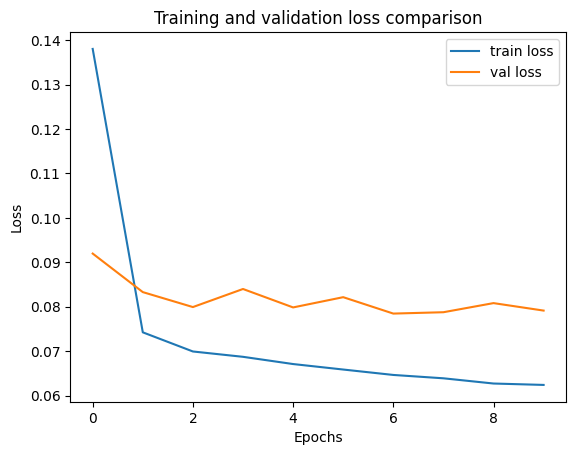

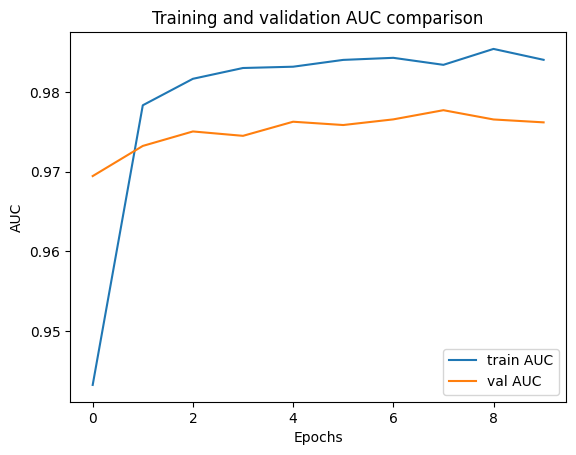

In [121]:
# Plot training and validation metrics

def plot_metrics(history):
    # Plot training and validation loss
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Training and validation loss comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation AUC
    plt.plot(history.history['auc'], label='train AUC')
    plt.plot(history.history['val_auc'], label='val AUC')
    plt.title('Training and validation AUC comparison')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

plot_metrics(nn_basic_history)

In [104]:
# predict the target with test dataset and convert it into binary output
nn_basic_predictions = (nn_basic_model.predict(X_test) > 0.5).astype(int)

142/142 [==============================] - 3s 20ms/step


Neural Network basic Model Accuracy:  0.9702643171806168
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       289
           1       0.98      0.99      0.98      4251

    accuracy                           0.97      4540
   macro avg       0.89      0.86      0.87      4540
weighted avg       0.97      0.97      0.97      4540



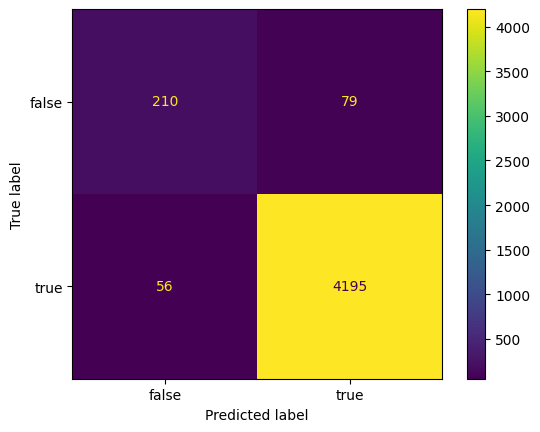

In [105]:
# plot confusion matrix
plot_confusion_matrix("Neural Network basic Model Accuracy: ", nn_basic_predictions)

**Neral Network Hyperparameter tuning**

In [127]:
# Function to create and compile the model.
def create_nn_model(optimizer, input_shape, regularization=None, dropout_rate=None, num_hidden_layers=1, num_neurons=64):
    nn_tuned_model = Sequential()
    nn_tuned_model.add(Dense(num_neurons, activation='relu', input_shape=input_shape, kernel_regularizer=regularization))
    if dropout_rate:
        nn_tuned_model.add(Dropout(dropout_rate))
    for _ in range(num_hidden_layers):
        nn_tuned_model.add(layers.Dense(num_neurons, activation='relu'))
        if dropout_rate:
            nn_tuned_model.add(Dropout(dropout_rate))
    nn_tuned_model.add(layers.Dense(1, activation='sigmoid'))

    nn_tuned_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return nn_tuned_model

# Define model configurations
model_configs = [
    {"num_hidden_layers": 1, "num_neurons": 64},
    {"num_hidden_layers": 2, "num_neurons": 128},
    {"num_hidden_layers": 3, "num_neurons": 256}
]

# model optimisers
optimizers = ['adam', 'rmsprop']

In [129]:
# define function to train the nn model
def train_nn_model(optimizer, config, X_training, X_validation, X_testing, regularization=None, dropout_rate=None):

    # define early stopping callback
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

    nn_tuned_model = create_nn_model(optimizer=optimizer, input_shape=X_training.shape[1:], regularization=regularization, dropout_rate=dropout_rate, **config)
    nn_tuned_history = nn_tuned_model.fit(X_training, y_train, epochs=50, batch_size=64, validation_data=(X_validation, y_valid), verbose=0, callbacks=[early_stopping_callback])

    loss, accuracy = nn_tuned_model.evaluate(X_testing, y_test, verbose=0)

    # View the output.
    print("optimizer:", optimizer)
    print("Configuration:", config)
    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
    print()

    return accuracy

best_config = ''
best_optimizer = ''
best_accuracy = 0

#train the model with various hyperparameter and get the best parameters
for optimizer in optimizers:
    for config in model_configs:
        accuracy = train_nn_model(optimizer, config, X_train, X_valid, X_test, regularization=regularizers.l2(0.01), dropout_rate=0.2)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_config = config
            best_optimizer = optimizer

#display best parameters
print("Best optimizer:", best_optimizer)
print("Best Configuration:", best_config)


optimizer: adam
Configuration: {'num_hidden_layers': 1, 'num_neurons': 64}
Test Loss: 0.0857049822807312, Test Accuracy: 0.9773975610733032

optimizer: adam
Configuration: {'num_hidden_layers': 2, 'num_neurons': 128}
Test Loss: 0.08565359562635422, Test Accuracy: 0.9754554033279419

optimizer: adam
Configuration: {'num_hidden_layers': 3, 'num_neurons': 256}
Test Loss: 0.0906052216887474, Test Accuracy: 0.9758785963058472

optimizer: rmsprop
Configuration: {'num_hidden_layers': 1, 'num_neurons': 64}
Test Loss: 0.0888756662607193, Test Accuracy: 0.9698287844657898

optimizer: rmsprop
Configuration: {'num_hidden_layers': 2, 'num_neurons': 128}
Test Loss: 0.08592338860034943, Test Accuracy: 0.976085364818573

optimizer: rmsprop
Configuration: {'num_hidden_layers': 3, 'num_neurons': 256}
Test Loss: 0.08956531435251236, Test Accuracy: 0.9690750241279602

Best optimizer: adam
Best Configuration: {'num_hidden_layers': 1, 'num_neurons': 64}


In [108]:
# define early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

nn_tuned_model = create_nn_model(optimizer=best_optimizer, input_shape=X_train.shape[1:], regularization=regularizers.l2(0.01), dropout_rate=0.2, **best_config)
nn_tuned_history = nn_tuned_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_valid, y_valid), verbose=0, callbacks=[early_stopping_callback])

# Evaluate the model
test_loss, test_accuracy = nn_tuned_model.evaluate(X_test, y_test, verbose=0)

# View the output.
print("\nShape of training data (y_train): ", y_train.shape)
print(f'Test Loss: {loss}, Test Accuracy: {test_accuracy}')


Shape of training data (y_train):  (14526, 1)
Test Loss: 0.07704728096723557, Test Accuracy: 0.9792965650558472


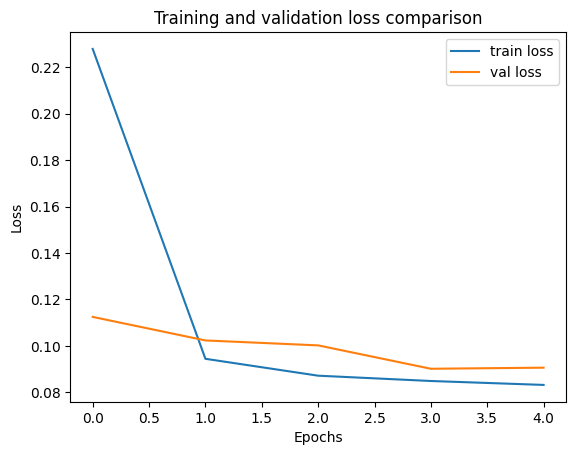

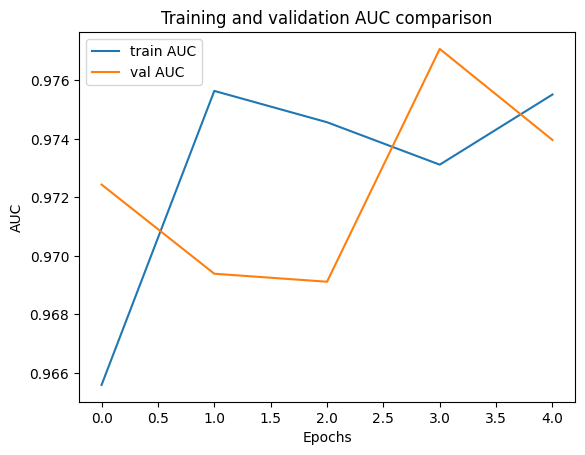

In [109]:
# Plot training and validation metrics
plot_metrics(nn_tuned_history)

In [110]:
# predict the target with test dataset and convert it into binary output
nn_tuned_predictions = (nn_tuned_model.predict(X_test) > 0.5).astype(int)

142/142 [==============================] - 1s 9ms/step


Neural Network tuned Model Accuracy:  0.9693832599118942
              precision    recall  f1-score   support

           0       0.80      0.70      0.74       289
           1       0.98      0.99      0.98      4251

    accuracy                           0.97      4540
   macro avg       0.89      0.84      0.86      4540
weighted avg       0.97      0.97      0.97      4540



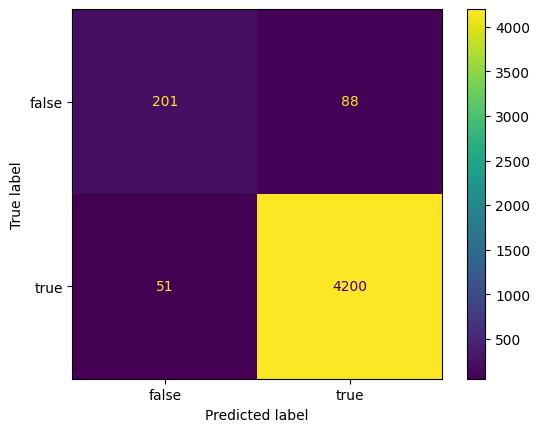

In [111]:
#plot confusion matrix
plot_confusion_matrix("Neural Network tuned Model Accuracy: ", nn_tuned_predictions)

* Neural Network basic Model Accuracy:  0.9789889454841614
* Neural Network tuned Model Accuracy:  0.9792965650558472

# Neural Network model with additional features

In [114]:
# split training data into training and validation data
X_extended_train, X_extended_valid, y_train, y_valid= train_test_split(X_extended_train, y_train_backup, stratify=y_train_backup, random_state=seed, test_size=0.2)

In [122]:
# Import necessary functions.
from keras.models import Sequential
from keras.layers import Dense

# Create a sequential model.
nn_basic_model = Sequential()

# Add dense layers to the model.
# First hidden layer with 128 units and ReLU activation.
nn_basic_model.add(Dense(units=128, activation='relu', input_shape=X_extended_train.shape[1:]))

# Second hidden layer with 64 units and ReLU activation.
nn_basic_model.add(Dense(units=64, activation='relu'))

# Output hidden layer with 1 unit (classes) and sigmoid activation.
nn_basic_model.add(Dense(units=1, activation='sigmoid'))

nn_basic_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 128)               7040      
                                                                 
 dense_74 (Dense)            (None, 64)                8256      
                                                                 
 dense_75 (Dense)            (None, 1)                 65        
                                                                 
Total params: 15361 (60.00 KB)
Trainable params: 15361 (60.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [123]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

optimizer = Adam(learning_rate=0.001)
# Compile the model.

nn_basic_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])

# Fit/Train the model.
nn_basic_history = nn_basic_model.fit(X_extended_train, y_train, batch_size=64, epochs=10, validation_data=(X_extended_valid, y_valid))

# Evaluate the model.
loss, accuracy = nn_basic_model.evaluate(X_extended_test, y_test)

# View the output.
print("\nShape of training data (y_train): ", y_train.shape)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/10
227/227 [==============================] - 3s 10ms/step - loss: 0.1218 - auc: 0.9535 - val_loss: 0.0727 - val_auc: 0.9833
Epoch 2/10
227/227 [==============================] - 4s 17ms/step - loss: 0.0629 - auc: 0.9850 - val_loss: 0.0705 - val_auc: 0.9822
Epoch 3/10
227/227 [==============================] - 2s 10ms/step - loss: 0.0579 - auc: 0.9867 - val_loss: 0.0660 - val_auc: 0.9827
Epoch 4/10
227/227 [==============================] - 2s 9ms/step - loss: 0.0543 - auc: 0.9884 - val_loss: 0.0642 - val_auc: 0.9856
Epoch 5/10
227/227 [==============================] - 1s 4ms/step - loss: 0.0525 - auc: 0.9876 - val_loss: 0.0608 - val_auc: 0.9862
Epoch 6/10
227/227 [==============================] - 2s 9ms/step - loss: 0.0508 - auc: 0.9898 - val_loss: 0.0595 - val_auc: 0.9865
Epoch 7/10
227/227 [==============================] - 4s 16ms/step - loss: 0.0492 - auc: 0.9910 - val_loss: 0.0619 - val_auc: 0.9858
Epoch 8/10
227/227 [==============================] - 2s 8ms/step - loss

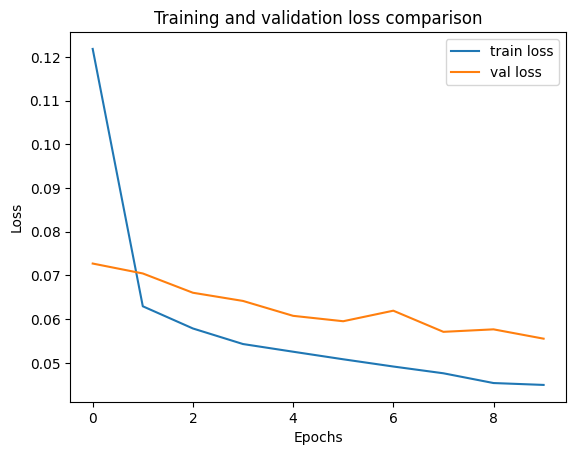

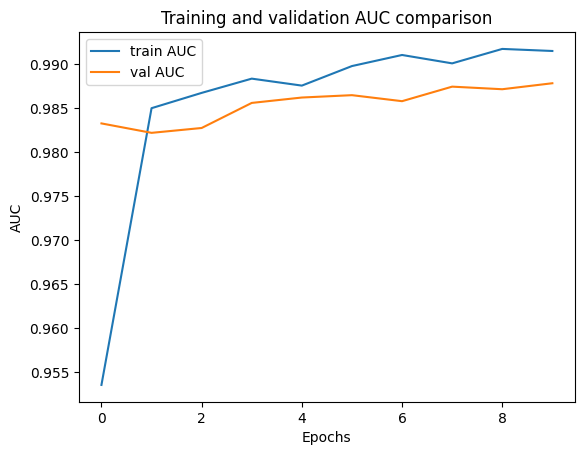

In [124]:
# Plot training and validation metrics
plot_metrics(nn_basic_history)

In [125]:
# predict the target with test dataset and convert it into binary output
nn_basic_predictions = (nn_basic_model.predict(X_extended_test) > 0.5).astype(int)

142/142 [==============================] - 1s 4ms/step


Neural Network basic Model Accuracy:  0.9764317180616741
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       289
           1       0.99      0.99      0.99      4251

    accuracy                           0.98      4540
   macro avg       0.90      0.91      0.90      4540
weighted avg       0.98      0.98      0.98      4540



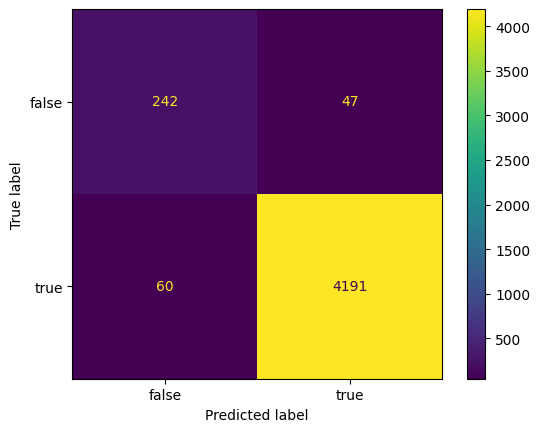

In [126]:
# plot confusion matrix
plot_confusion_matrix("Neural Network basic Model Accuracy: ", nn_basic_predictions)

**Neral Network Hyperparameter tuning**

In [130]:
best_config = ''
best_optimizer = ''
best_accuracy = 0

#train the model with various hyperparameter and get the best parameters
for optimizer in optimizers:
    for config in model_configs:
        accuracy = train_nn_model(optimizer, config, X_extended_train, X_extended_valid, X_extended_test, regularization=regularizers.l2(0.01), dropout_rate=0.2)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_config = config
            best_optimizer = optimizer

#display best parameters
print("Best optimizer:", best_optimizer)
print("Best Configuration:", best_config)

optimizer: adam
Configuration: {'num_hidden_layers': 1, 'num_neurons': 64}
Test Loss: 0.07209166884422302, Test Accuracy: 0.9854001402854919

optimizer: adam
Configuration: {'num_hidden_layers': 2, 'num_neurons': 128}
Test Loss: 0.07529588043689728, Test Accuracy: 0.9867302179336548

optimizer: adam
Configuration: {'num_hidden_layers': 3, 'num_neurons': 256}
Test Loss: 0.07071251422166824, Test Accuracy: 0.9823880195617676

optimizer: rmsprop
Configuration: {'num_hidden_layers': 1, 'num_neurons': 64}
Test Loss: 0.07325449585914612, Test Accuracy: 0.9818886518478394

optimizer: rmsprop
Configuration: {'num_hidden_layers': 2, 'num_neurons': 128}
Test Loss: 0.07696075737476349, Test Accuracy: 0.9791443347930908

optimizer: rmsprop
Configuration: {'num_hidden_layers': 3, 'num_neurons': 256}
Test Loss: 0.073149673640728, Test Accuracy: 0.9851579666137695

Best optimizer: adam
Best Configuration: {'num_hidden_layers': 2, 'num_neurons': 128}


In [131]:
# define early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

nn_tuned_model = create_nn_model(optimizer=best_optimizer, input_shape=X_extended_train.shape[1:], regularization=regularizers.l2(0.01), dropout_rate=0.2, **best_config)
nn_tuned_history = nn_tuned_model.fit(X_extended_train, y_train, epochs=50, batch_size=64, validation_data=(X_extended_valid, y_valid), verbose=0, callbacks=[early_stopping_callback])

# Evaluate the model
test_loss, test_accuracy = nn_tuned_model.evaluate(X_extended_test, y_test, verbose=0)

# View the output.
print("\nShape of training data (y_train): ", y_train.shape)
print(f'Test Loss: {loss}, Test Accuracy: {test_accuracy}')


Shape of training data (y_train):  (14526, 1)
Test Loss: 0.056782566010951996, Test Accuracy: 0.9844355583190918


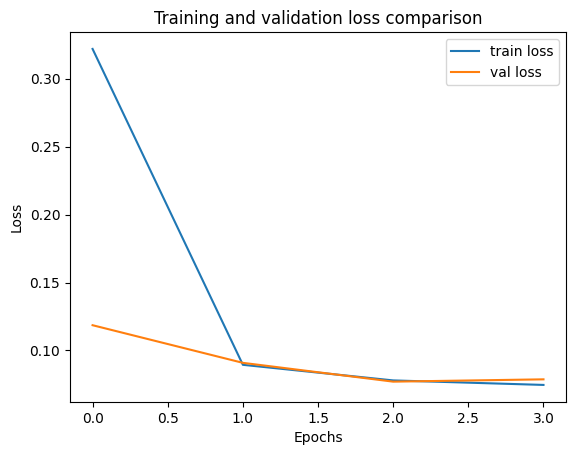

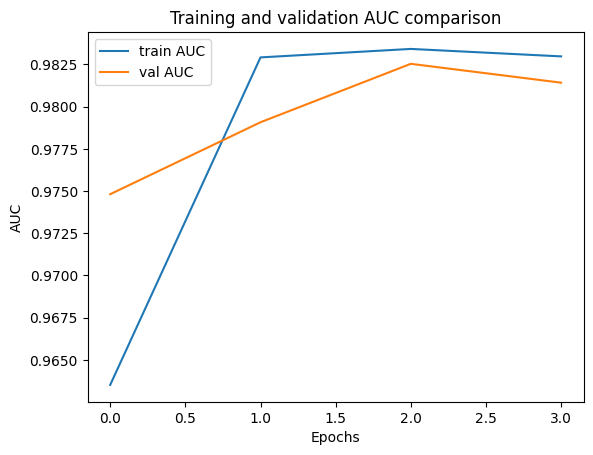

In [132]:
# Plot training and validation metrics
plot_metrics(nn_tuned_history)

In [134]:
# predict the target with test dataset and convert it into binary output
nn_tuned_predictions = (nn_tuned_model.predict(X_extended_test) > 0.5).astype(int)

142/142 [==============================] - 0s 2ms/step


Neural Network tuned Model Accuracy:  0.9755506607929515
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       289
           1       0.99      0.99      0.99      4251

    accuracy                           0.98      4540
   macro avg       0.90      0.90      0.90      4540
weighted avg       0.98      0.98      0.98      4540



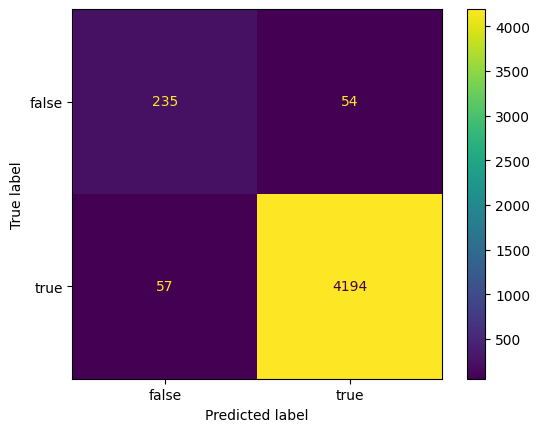

In [135]:
# plot confusion matrix
plot_confusion_matrix("Neural Network tuned Model Accuracy: ", nn_tuned_predictions)

**With Additional features**

* Neural Network basic Model Accuracy:  0.986534833908081
* Neural Network tuned Model Accuracy:  0.9844355583190918

The basic model of Neural Network with additional features predicted with 98.65% accuracy.

The False Positive is lower than False Negative which is good as we would like True Negative to tend towards 100%


Hyperparameter tuning gave the following as the best parameters:
*	optimizer: adam
*	num_hidden_layers: 2
*	num_neurons: 128

Using the hyperparameter values, the Neural Network model gave 98.44% accuracy, resulting in slight degradation in the recall for the negative class.

**Conclusion**

Comparing XGBoost and Neural Network, the latter performed slightly better on this dataset, but the difference is less than a percentage point. Therefore, I would conclude they are very similar. Additionally, both models performed better with the 2 additional features.

Similarly, the performance of both models seemed to degrade after hyperparameter tuning. Again, the difference is less than a percentage point and therefore hyperparameter tuning is still beneficial in terms of performance improvement and reduced computational cost. It also ensures the models are not overfitted.

We were able to determine the features that were important in making the prediction using XGBoost. CreditWeightedAverage seems to make much higher impact than any other features. ContactHours is in the top 15 features confirming its importance as confirmed by the 2 models’s improvement after the 2 additional features were added.

The models could be tuned better with tuning additional hyperparameters if time allowed. However, as the accuracy is already above 98% the models are already near optimal as we have observed that there are good number of outliers in the data. The model could be tuned to predict the negative class more accurately at the cost of overall accuracy as this would ensure that institutions could target most, if not all, students who are likely to drop out.
